Импорт библиотек, необходимых для работы с данными

In [2]:
import pandas as pd # для большинства операций с датафреймом
import numpy as np # для обработки значений
import matplotlib.pyplot as plt #графики
import seaborn as sns # еще графики
from scipy.stats import shapiro as shp # этот для тестиков на нормальность
from scipy.stats import kstest # этот тоже для тестиков на нормальность
from datetime import datetime as dt # для работы со временем
from datetime import date # для работы со временем
from scipy.stats import mannwhitneyu as mnw # для поиска p-value на ненормальных данных с разной шкалой отклика
from scipy.stats import spearmanr as spr # для поиска p-value на ненормальном распределении данных с количественной шкалой отклика
from scipy.stats import ttest_ind as ttest # для поиска p-value на нормальных данных с разной шкалой отклика
from sklearn.preprocessing import OneHotEncoder # для замены категориальных данных на бинарные шкалы с 1 и 0
from sklearn.model_selection import train_test_split as tr # для разбиения данных на обучающую и тестовую выборки
from sklearn.linear_model import LinearRegression # для обучение нашей модели
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error # для проверки нашей модели
from math import ceil # для округления результатов проверки нашей модели
import pickle # для сохранения модели

C:\Users\yaros\AppData\Local\Temp\ipykernel_27096\1672966723.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd # для большинства операций с датафреймом


Предобработка rides

Загрузка данных и привод к стандарту PEP8 заголовков и данных, приводим к нужным типам данных

In [8]:
df_rides = pd.read_csv('rides.csv', encoding='utf-8', sep=',', decimal='.', skipinitialspace=True).rename(
    columns=lambda x: x.replace(' ', '_').lower()
).fillna(np.nan)
#загрузил данные по таблице "rides"
for colum in ['start_location', 'start_district', 'end_location', 'end_district']:
    df_rides[colum] = df_rides[colum].apply(lambda x: x[4:].lower().replace(' ', '_').replace('-', '_')
    if 'ул. ' in x.lower() else (x[3:].lower().replace(' ', '_').replace('-', '_')
    if 'ул.' in x.lower() or 'ул ' in x.lower() else (x[2:].lower().replace(' ', '_').replace('-', '_')
    if 'ул' in x.lower() else x.lower().replace(' ', '_').replace('-', '_')))) # так как везде разные подписи улиц, а где-то их нет
#привел к pep8 названия улиц
for colum in ['start_date', 'end_date']:
    df_rides[colum] = pd.to_datetime(df_rides[colum])
#привел к формату времени из типа string
df_rides['start'] = df_rides.apply(lambda x:(x['start_location'], x['start_district']), axis=1)
df_rides['end'] = df_rides.apply(lambda x:(x['end_location'], x['end_district']), axis=1)
# df_rides = df_rides.drop(columns=['start_location', 'start_district', 'end_location', 'end_district'])
df_rides['day_of_week'] = df_rides['start_date'].apply(lambda x:x.day_of_week) # добавим день недели, так как в разные дни недели могут быть разные маршруты, к примеру по выходным люди могут енхать к метро не так спеша, как пор будням, заехав куда-нибудь
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго_восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо_западный    3881.0      0   
4  северо_западный    юбилейная    юго_восточный    4029.0      0   

                             start                         end  day_of_week  
0        (шевченко, юго_восточный)      (майская, октябрьский)            5  
1               (чехова, заречный)   (спортивная, октябрьский)            5  
2         (буденного, октябрьский)       (суворова, ленинский)            5  
3             (труда, центральный)  (рабочая, северо_западный)            5  
4  (первомайская, северо_западный)  (юбилейная, юго_восточный)            5

Удалим дубликаты данных

In [9]:
df_rides = df_rides.drop_duplicates()

In [10]:
print(shp(df_rides['distance'].dropna())) # проверка на нормальность данных в дистансе

ShapiroResult(statistic=0.05048424005508423, pvalue=0.0)


c:\Users\yaros\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Найдем выбросы в дистанции

In [11]:
qr3_dist = 3 * (df_rides['distance'].quantile(0.75) - df_rides['distance'].quantile(0.25))
median_dist = df_rides['distance'].median()
#для поиска интерквартильного размаха
df_rides_quantil = df_rides['distance'].quantile(0.05)
group_dist = df_rides[['day_of_week', 'start', 'end', 'distance']].groupby(['day_of_week', 'start', 'end']).median() #группировка по району и улице
group_district = df_rides[['day_of_week', 'start_district', 'end_district', 'distance']].groupby(['day_of_week', 'start_district', 'end_district']).median() #группировка по району, менее точная, но когда нет совпадающих данных по улице и району, это дает приближенный результат
# print(group_district)
# print(df_rides['distance'].median(), df_rides['distance'].mean())


def dist_blowout(x): # о, это чисто функция со спадающим уровнем точности, сначала по районам и улицам, потом по районам чисто смотрим, а потом уже просто медиану ставим
    if median_dist - qr3_dist > x['distance']  or  x['distance'] > median_dist  + qr3_dist or x['distance'] < df_rides_quantil:
        try:
            return group_dist[x['day_of_week']][x['start']][x['end']]
        except:
            try:
                return group_dist[x['day_of_week']][x['end']][x['start']] # меняю местами, так как по идее расстояние должно быть таким же
            except:
                try:
                    return group_district[x['day_of_week']][x['start_district']][x['end_district']]
                except:
                    try:
                        return group_district[x['day_of_week']][x['end_district']][x['start_district']]
                    except:
                        return median_dist
    return x['distance']


df_rides['distance'] = df_rides.apply(dist_blowout, axis=1)

Узнаем, где есть пропуски в данных

In [ ]:
df_rides.isna().sum()

id                   0
start_date           0
end_date           555
start_location       0
start_district       0
end_location         0
end_district         0
distance          1181
promo                0
start                0
end                  0
day_of_week          0
dtype: int64

Заполним пропуски в дистанции

Проверим данные на нормальность распределения

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9732835292816162, pvalue=0.0)


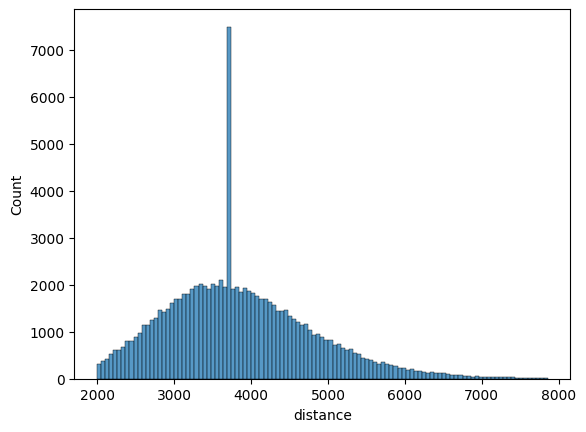

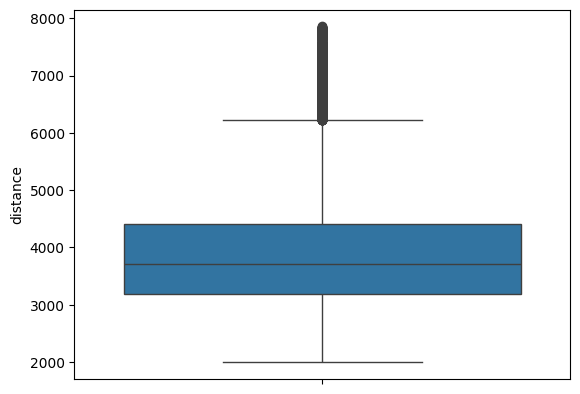

In [ ]:
print(shp(df_rides['distance'].dropna()))
sns.histplot(df_rides['distance'])
plt.show()
sns.boxplot(df_rides['distance'])
plt.show()

Как мы видим, данные распределены ненормально, значит для рассчёта значения, которое мы будем подставлять вместо нуля, будет среднее медианное выборки наших дистанций без каких-либо данных по району и улице

In [12]:
# далее - пересчет уже для поиска нулей по данным без выбросов
group_dist_2 = df_rides[['day_of_week', 'start', 'end', 'distance']].groupby(['day_of_week', 'start', 'end']).median() #группировка по району и улице (медиана, так как их распределение неизвестно)
group_district_2 = df_rides[['day_of_week', 'start_district', 'end_district', 'distance']].groupby(['day_of_week', 'start_district', 'end_district']).median() #группировка по району
mean = df_rides['distance'].median()
# print(group_district_2)


def dist_Nan(x):
    if not(np.isnan(x['distance'])):
        return x['distance']
    try:
        return group_dist_2[x['day_of_week']][x['start']][x['end']]
    except:
        try:
            return group_dist_2[x['day_of_week']][x['end']][x['start']]
        except:
            try:
                return group_district_2[x['day_of_week']][x['start_district']][x['end_district']]
            except:
                try:
                    return group_district_2[x['day_of_week']][x['end_district']][x['start_district']]
                except:
                    return mean


df_rides['distance'] = df_rides.apply(dist_Nan, axis=1)

Обработаем выбросы в end_date

In [13]:
group_enddate_max = df_rides[['day_of_week', 'start', 'end', 'end_date']].groupby(['day_of_week', 'start', 'end']).median() #группировка по району и улице (медиана, так как их распределение неизвестно)
group_enddate = df_rides[['day_of_week', 'start_district', 'end_district', 'end_date']].groupby(['day_of_week', 'start_district', 'end_district']).median() #группировка по району
mean_enddate = df_rides['end_date'].median()
qr3_enddate = 3 * (df_rides['end_date'].quantile(0.75) - df_rides['end_date'].quantile(0.25))
median_enddate = df_rides['end_date'].median()


def date_blowout(x):
    if x['end_date'] > x['start_date']:
        return x['end_date']
    try:
        res = group_dist_2[x['day_of_week']][x['start']][x['end']]
    except:
        try:
            res = group_dist_2[x['day_of_week']][x['end']][x['start']]
        except:
            try:
                res = group_district_2[x['day_of_week']][x['start_district']][x['end_district']]
            except:
                try:
                    res = group_district_2[x['day_of_week']][x['end_district']][x['start_district']]
                except:
                    res = 0
    if pd.to_datetime(res) <= x['start_date']:
        return np.nan
    return res


df_rides['end_date'] = df_rides.apply(date_blowout, axis=1)
df_rides.isna().sum()

id                  0
start_date          0
end_date          555
start_location      0
start_district      0
end_location        0
end_district        0
distance            0
promo               0
start               0
end                 0
day_of_week         0
dtype: int64

Заполним пропуски в конечном времени


In [14]:
def time(x):
    try:
        return pd.Timedelta(x['end_date'] - x['start_date']).seconds / 60
    except:
        return np.nan


df_rides['time'] = df_rides.apply(time, axis=1) #создадим новую категорию "time" для обозначения времени в минутах, которое проехал человек на самокате
# raspred = df_rides.set_index('start_date')[['time', 'distance']].resample('5min').median() #создали группировку по улицам и районам для поиска среднего перемещения
# print(raspred)

Проверка time на нормальность распределения

c:\Users\yaros\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.9261610507965088, pvalue=0.0)


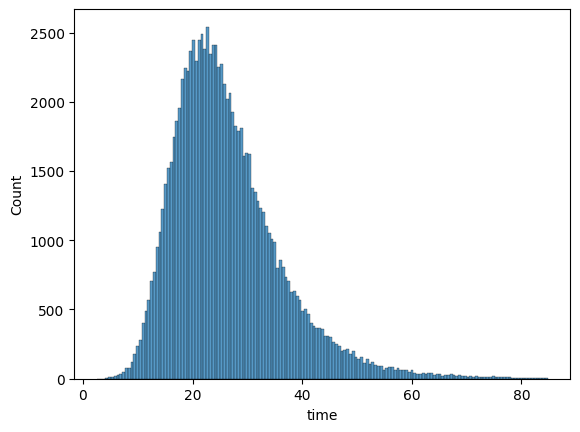

In [15]:
print(shp(df_rides['time'].dropna()))
sns.histplot(df_rides['time'])
plt.show()

Данные распределены ненормально, значит заполняем медианой

Сначала заполним пропуски по времени

C:\Users\yaros\AppData\Local\Temp\ipykernel_27096\429278448.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_rides[df_rides.distance > x.distance - 200][df_rides.distance < x.distance + 200]['time'].median() # найдем медиану времени по приблизительной дистанции, когда нет данных по другим перемещениям конкретно по нашим заданным точкам
C:\Users\yaros\AppData\Local\Temp\ipykernel_27096\429278448.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_rides[df_rides.distance > x.distance - 200][df_rides.distance < x.distance + 200]['time'].median() # найдем медиану времени по приблизительной дистанции, когда нет данных по другим перемещениям конкретно по нашим заданным точкам
C:\Users\yaros\AppData\Local\Temp\ipykernel_27096\429278448.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  return df_rides[df_rides.distance > x.distance - 200][df_rides.distance < x.distance + 

ShapiroResult(statistic=0.9323545694351196, pvalue=0.0)


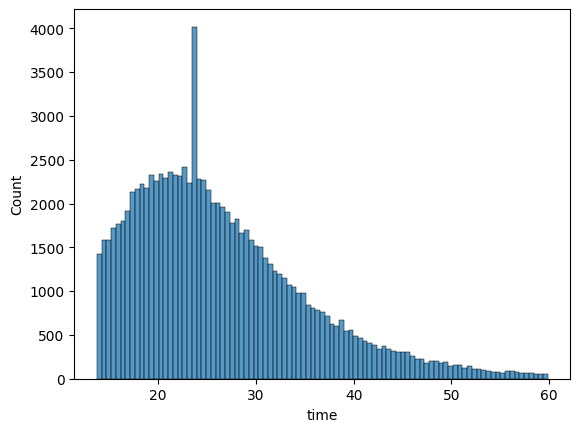

In [16]:
groups_for_time_max = df_rides[['day_of_week', 'start', 'end', 'time']].groupby(['day_of_week', 'start', 'end']).median() #группировка по дню недели и районам с улицей, тк в разные дни могут быть разные маршруты
groups_for_time = df_rides[['day_of_week', 'start_district', 'end_district', 'time']].groupby(['day_of_week', 'start_district', 'end_district']).median() # группировка по дням и районам
qr3_time = 3 * (df_rides['time'].quantile(0.75) - df_rides['time'].quantile(0.25))
median_time = df_rides['time'].median()
#для поиска интерквартильного размаха
df_rides_quantil_time = df_rides['time'].quantile(0.05)


def time_not_found(x):
    return df_rides[df_rides.distance > x.distance - 200][df_rides.distance < x.distance + 200]['time'].median() # найдем медиану времени по приблизительной дистанции, когда нет данных по другим перемещениям конкретно по нашим заданным точкам


def time_blowout(x):
    if (x['time'] < df_rides_quantil_time or median_time - qr3_time > x['time']  or  x['time'] > median_time  + qr3_time):
        try:
            if groups_for_time_max[x['day_of_week']][x['start']][x['end']] > df_rides_quantil_time:
                return groups_for_time_max[x['day_of_week']][x['start']][x['end']]
            return time_not_found(x)
        except:
            try:
                if groups_for_time_max[x['day_of_week']][x['end']][x['start']] > df_rides_quantil_time:
                    return groups_for_time_max[x['day_of_week']][x['end']][x['start']]
            except:
                try:
                    if groups_for_time[x['day_of_week']][x['start_district']][x['end_district']] > df_rides_quantil_time:
                        return groups_for_time[x['day_of_week']][x['start_district']][x['end_district']]
                except:
                    try:
                        if groups_for_time[x['day_of_week']][x['end_district']][x['start_district']] > df_rides_quantil_time:
                            return groups_for_time[x['day_of_week']][x['end_district']][x['start_district']]
                    except:
                        pass
            return time_not_found(x)
    return x['time']


df_rides['time'] = df_rides.apply(time_blowout, axis=1)
print(shp(df_rides['time'].dropna()))
sns.histplot(df_rides['time'])
plt.show()

Переходим к заполнению времени окончания поездки, для начала рассчитаем среднюю скорость по поездкам на самокатах из разных точек

In [17]:
df_rides['avg_V'] = df_rides.apply(lambda x:x['distance'] / x['time'], axis=1)
groups_for_v_max_2 = df_rides[['day_of_week', 'start', 'end', 'avg_V']].groupby(['day_of_week', 'start', 'end']).median()
groups_for_v_2 = df_rides[['day_of_week', 'start_district', 'end_district', 'avg_V']].groupby(['day_of_week', 'start_district', 'end_district']).median()
# print(set([type(elem) for elem in set(df_rides['end_date'])]))


def end_date_isnan(x):
    if not(pd.isnull(x['end_date'])):
        return x['end_date']
    try:
        time_of_travel = x['distance'] / groups_for_v_max_2[x['day_of_week']][x['start']][x['end']]
    except:
        try:
            time_of_travel = x['distance'] / groups_for_v_max_2[x['day_of_week']][x['end']][x['start']]
        except:
            try:
                time_of_travel = x['distance'] / groups_for_v_2[x['day_of_week']][x['start_district']][x['end_district']]
            except:
                try:
                    time_of_travel = x['distance'] / groups_for_v_2[x['day_of_week']][x['end_district']][x['start_district']]
                except:
                    time_of_travel = x['distance'] / df_rides['avg_V'].median()
    return x['start_date'] + pd.to_timedelta(60 * time_of_travel, unit='s')


df_rides['end_date'] = df_rides.apply(end_date_isnan, axis=1)
# также ниже заполним нули time и скорости
df_rides['time'] = df_rides.apply(lambda x:pd.Timedelta(x['end_date'] - x['start_date']).seconds / 60, axis=1)
df_rides['avg_V'] = df_rides.apply(lambda x:x['distance'] / x['time'], axis=1)

In [18]:
# так как файл был слишком большой и его не пропускал гитхаб, я удалил графу со скоростью
# df_rides = df_rides.drop(columns='avg_V')
# даже так он 26 мб, а не 25... а так ли нам нужны айдишники пользователей:)))
# ладно, кроме шуток, номер дня недели нам скорее всего понадобится, а start и end я делал дополнительные чисто для удобства собственных вычислений и группировки, так что удаляю их, а скорость возвращаю
df_rides = df_rides.drop(columns=['start', 'end'])
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго_восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо_западный    3881.0      0   
4  северо_западный    юбилейная    юго_восточный    4029.0      0   

   day_of_week       time       avg_V  
0            5  23.700000  171.687764  
1            5  28.416667  158.885630  
2            5  38.316667  117.964332  
3            5  31.816667  121.980094  
4            5  30.666667  131.380435

In [20]:
df_rides.to_csv('rides_after_processing.csv')

Далее просмотрим данные по weather.csv

In [22]:
df_weath = pd.read_csv('weather.csv', encoding='utf-8', sep=',', decimal='.', skipinitialspace=True).rename(
    columns=lambda x: x.replace(' ', '_').lower()
).fillna(np.nan).iloc[1:]
df_weath.head()

datetime temperature precipitation_total wind_gust wind_speed  \
1  2023-04-01T00:00:00    8.740245                 0.1      48.6  21.638964   
2  2023-04-01T01:00:00    9.040245                 0.2     55.44  22.493519   
3  2023-04-01T02:00:00    8.880245                 0.3      55.8   22.26477   
4  2023-04-01T03:00:00    8.690246                 0.3     55.44   21.94524   
5  2023-04-01T04:00:00    8.630245                 0.3     48.96   22.42427   

  cloud_cover_total sunshine_duration  
1                90                 0  
2                74                 0  
3                72                 0  
4                77                 0  
5                78                 0

Привод к нужным типам данных

In [23]:
df_weath['datetime'] = df_weath['datetime'].apply(lambda x:pd.to_datetime(x)) # приводим ко временному формату дату
for colum in ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration']:
    df_weath[colum] = df_weath[colum].astype('float')
df_weath.head()

datetime  temperature  precipitation_total  wind_gust  \
1 2023-04-01 00:00:00     8.740245                  0.1      48.60   
2 2023-04-01 01:00:00     9.040245                  0.2      55.44   
3 2023-04-01 02:00:00     8.880245                  0.3      55.80   
4 2023-04-01 03:00:00     8.690246                  0.3      55.44   
5 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  
1   21.638964               90.0                0.0  
2   22.493519               74.0                0.0  
3   22.264770               72.0                0.0  
4   21.945240               77.0                0.0  
5   22.424270               78.0                0.0

In [24]:
# смотрим, что все файлы приведены правильно
[type(elem) for elem in df_weath.iloc[0]]

[pandas._libs.tslibs.timestamps.Timestamp,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64]

Избавимся от дубликатов

In [25]:
df_weath = df_weath.drop_duplicates()

Проверяем на нули

In [ ]:
df_weath.isna().sum()

datetime                0
temperature            55
precipitation_total    30
wind_gust               0
wind_speed             16
cloud_cover_total      20
sunshine_duration      12
dtype: int64

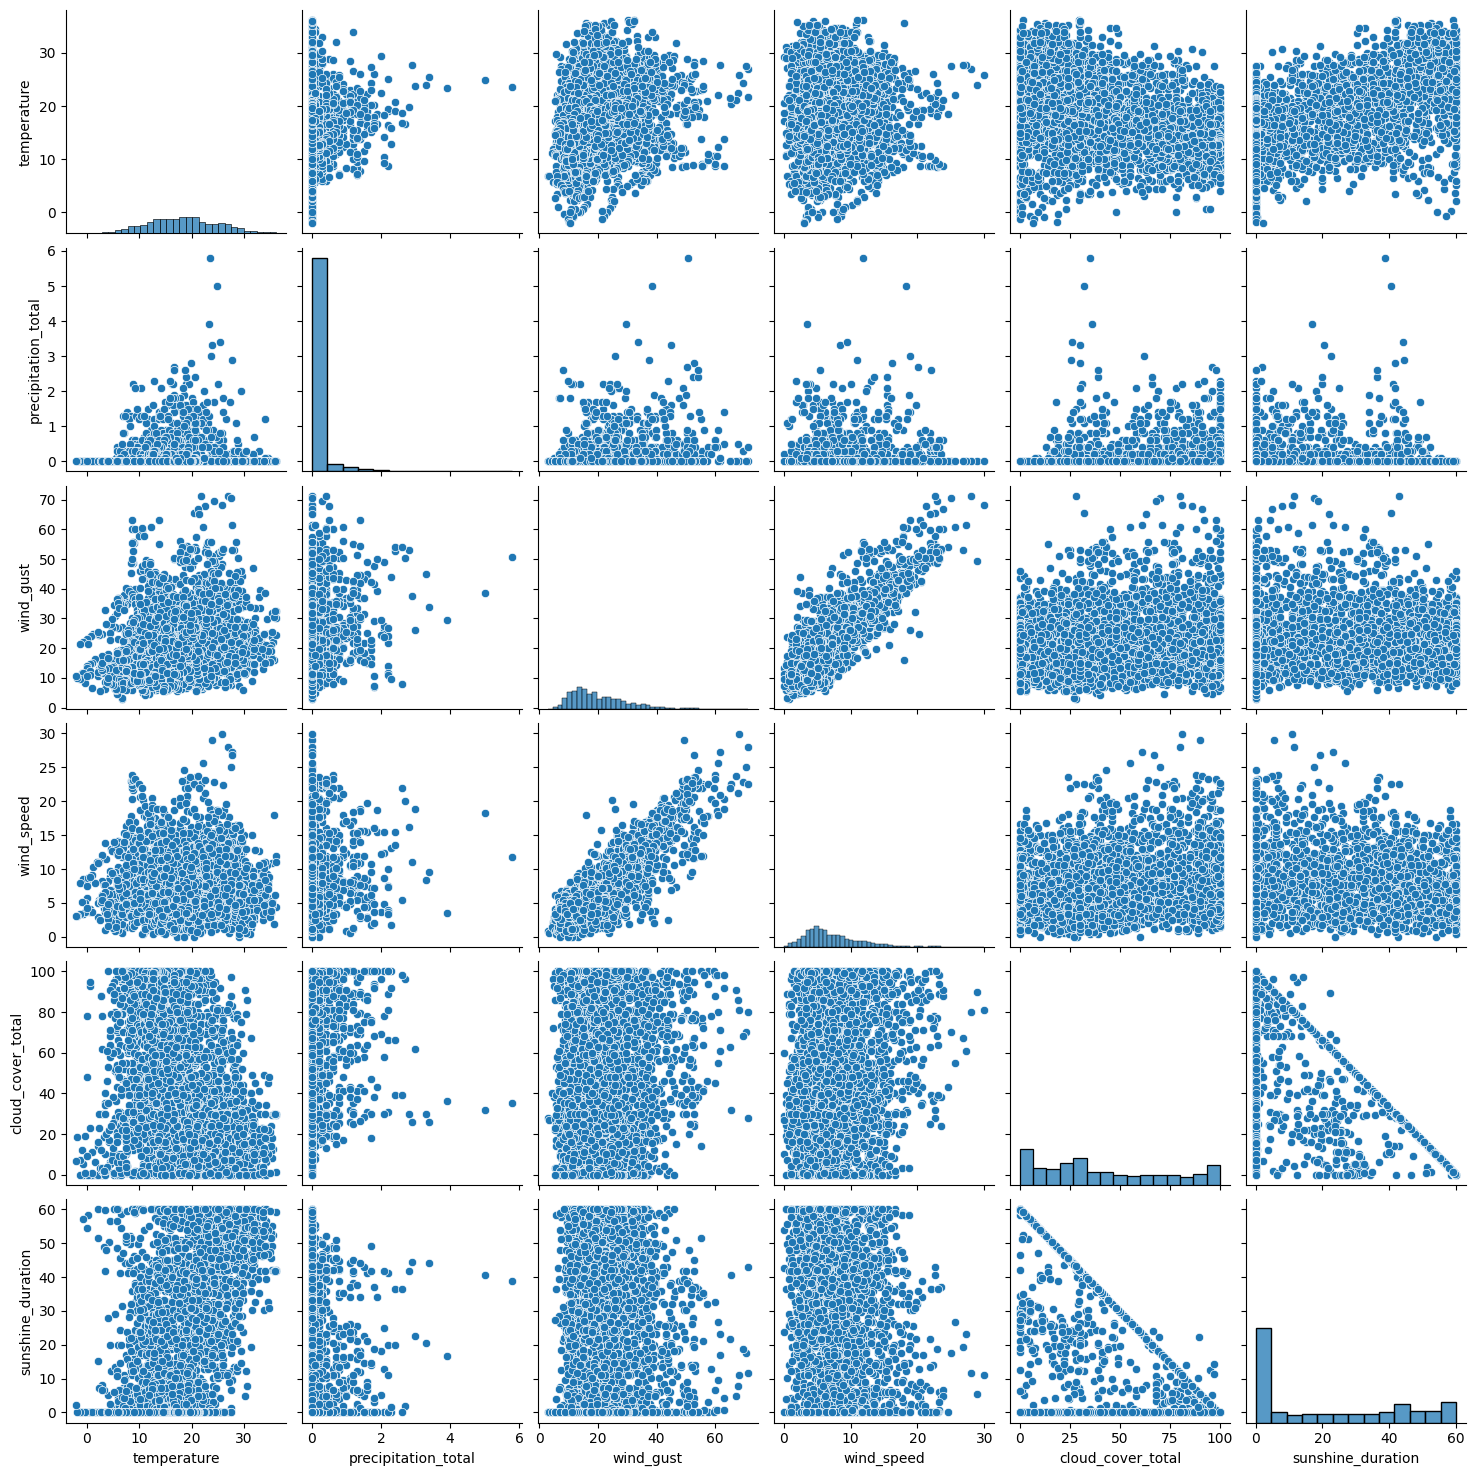

In [ ]:
sns.pairplot(df_weath.iloc[:, 1:])
plt.show()

In [26]:
# заполнения нули в нашем датасете
for colum in ['temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total', 'sunshine_duration']:
    df_weath[colum] = df_weath[colum].interpolate() # так как это погодные данные, то они меняются плавно, используем метод interpolate
df_weath.isna().sum()

datetime               0
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64

Сохраним обработанную таблицу

In [ ]:
df_weath.to_csv('/content/drive/MyDrive/Шеринг самокатов/weather_after_processing.csv')

Объединим данные в 2 датафреймах, логично понять, что объединение происходит по дате и времени

In [27]:
# создадим новый датафрейм df_full как копию df_rides для добавления данных из второй таблицы
df_full = df_rides.copy()
# df_full = pd.read_csv('/content/drive/MyDrive/Шеринг самокатов/df_full.csv', sep=',', decimal='.').iloc[:, 1:]
# for colum in ['start_date', 'end_date']:
#     df_full[colum] = pd.to_datetime(df_rides[colum])


def united_df(x, colum):
    datetime_for_weath = x['start_date'].date()
    return df_weath[df_weath.datetime == pd.to_datetime(datetime_for_weath)][colum].median()


for colum in df_weath.columns[1:]:
    df_full[colum] = df_rides.apply(lambda x:united_df(x, colum), axis=1)
print(df_full.isna().sum())
df_full.head()

id                     0
start_date             0
end_date               0
start_location         0
start_district         0
end_location           0
end_district           0
distance               0
promo                  0
day_of_week            0
time                   0
avg_V                  0
temperature            0
precipitation_total    0
wind_gust              0
wind_speed             0
cloud_cover_total      0
sunshine_duration      0
dtype: int64


id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго_восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо_западный    3881.0      0   
4  северо_западный    юбилейная    юго_восточный    4029.0      0   

   day_of_week       time       avg_V  temperature  precipitation_total  \
0            5  23.700000  171.687764     8.640245                  0.0   
1            5  28.416667  158.885630     8.640245                  0.0   
2            5  38.316667  117.964332     8.640245                  0.0   
3            5  31.816667  121.980094     8.640245                  0.0   
4            5  30.666667  131.380435     8.640245                  0.0   

   wind_gust  wind_speed  cloud_cover_total  sunshine_duration  
0      15.48    8.217153               65.0                0.0  
1      15.48    8.217153               65.0                0.0  
2      15.48    8.217153               65.0                0.0  
3      15.48    8.217153               65.0                0.0  
4      15.48    8.217153               65.0                0.0

Сохраним наш объединенный датафрейм

In [ ]:
df_full.to_csv('/content/drive/MyDrive/Шеринг самокатов/df_full.csv')

______________________________________________________________________________________________________

Проверка гипотез

In [ ]:
# Сходу напишем функцию для проверки гипотез
def hip_right_or_not(p_val):
    if p_val < 0.05:
        return 'Нулевая гипотеза отвергается'
    else:
        return 'Нулевая гипотеза отвергается'

Гипотеза номер 5: в будние дни поездки имеют такую же скорость, что и в выходные

Первым делом создадим 2 категории данных: поездки в будние и выходные дни, а также проверим их на нормальность

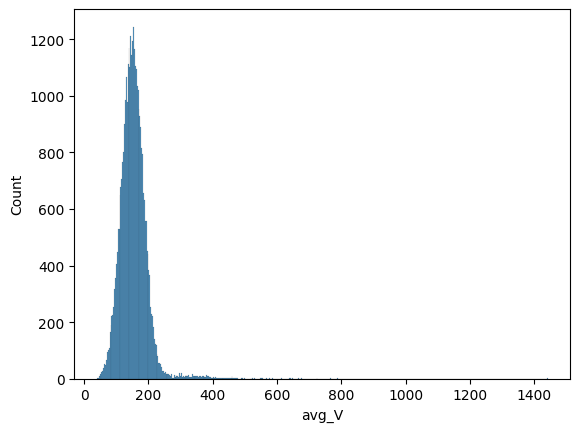

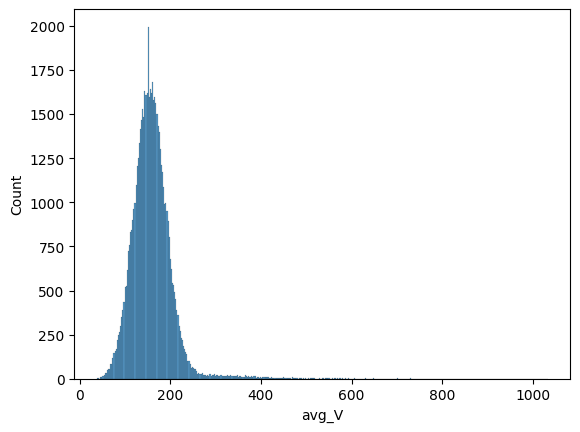

ShapiroResult(statistic=0.83780837059021, pvalue=0.0) Будние
ShapiroResult(statistic=0.8548392057418823, pvalue=0.0) Выходные


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
df_full['day_cat'] = df_full['day_of_week'].apply(lambda x: 'weekend' if x >= 5 else 'weekday')
sns.histplot(df_full[df_full.day_cat == 'weekend']['avg_V']) # массив выходных поездок
plt.show()
sns.histplot(df_full[df_full.day_cat == 'weekday']['avg_V']) # массив будних поездок
plt.show()
print(shp(df_full[df_full.day_cat == 'weekday']['avg_V']), 'Будние')
print(shp(df_full[df_full.day_cat == 'weekend']['avg_V']), 'Выходные')

Ищем средние исходя из того, что у нас ненормальные данные

In [ ]:
print(f"{df_full[df_full.day_cat == 'weekday']['avg_V'].median()} скорость в будние дни\n{df_full[df_full.day_cat == 'weekend']['avg_V'].median()} скорость в выходные дни")

155.5394641564084 скорость в будние дни
150.72046109510086 скорость в выходные дни


По графику видно, и аналитикой доказано, что в будние скорость поездки выше

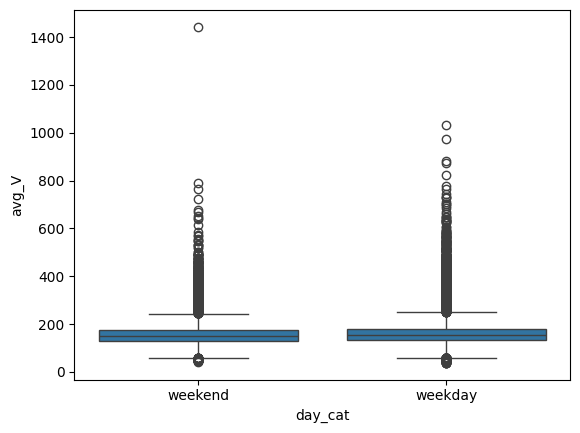

In [ ]:
sns.boxplot(x='day_cat', y='avg_V', data=df_full)
plt.show()

Данные распределены ненормально, шкалы разные, значит для работы используем тест Манн-Уитни

In [ ]:
hipot_5 = mnw(df_full[df_full.day_cat == 'weekday']['avg_V'], df_full[df_full.day_cat == 'weekend']['avg_V'])
print(f'{hip_right_or_not(hipot_5[1])}, так как p-value равен {hipot_5[1]}')

Нулевая гипотеза отвергается, так как p-value равен 3.9674346105644636e-99


Нулевая гипотеза отвергнута, а значит, что мы можем сказать, что в будние дни скорость выше

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Гипотеза номер 4: в выходные и будние дни поездки имеют приблизительно одинаковую скорость

У нас уже созданы переменные для категоризации дней на будние и выходные, так что мы переходим сразу к проверке гипотезы

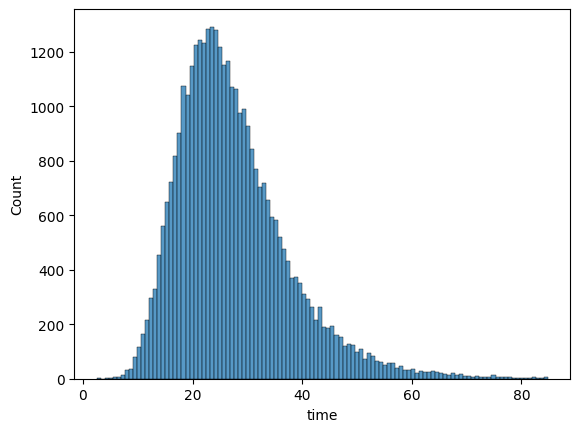

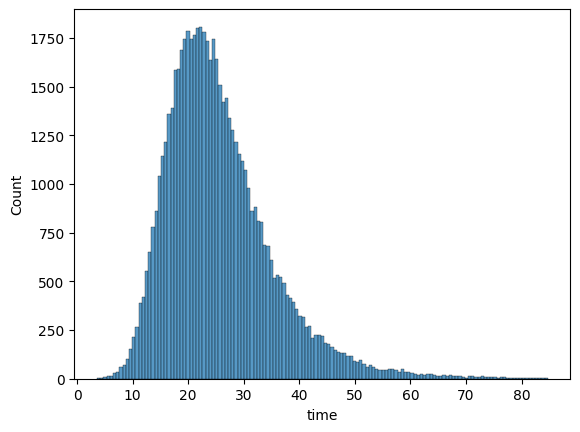

ShapiroResult(statistic=0.9307454228401184, pvalue=0.0) Выходные
ShapiroResult(statistic=0.9234426021575928, pvalue=0.0) Будние


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
sns.histplot(df_full[df_full.day_cat == 'weekend']['time']) # массив выходных поездок
plt.show()
sns.histplot(df_full[df_full.day_cat == 'weekday']['time']) # массив будних поездок
plt.show()
print(shp(df_full[df_full.day_cat == 'weekend']['time']), 'Выходные')
print(shp(df_full[df_full.day_cat == 'weekday']['time']), 'Будние')
# проверяем на нормальность

In [ ]:
#Ищем средние исходя из того, что у нас ненормальные данные
print(f"{df_full[df_full.day_cat == 'weekday']['time'].median()} среднее время в будние дни\n{df_full[df_full.day_cat == 'weekend']['time'].median()} среднее время в выходные дни")

24.0 среднее время в будние дни
25.733333333333334 среднее время в выходные дни


Данные распределены ненормально, значит используем Манн-Уитни

In [ ]:
hipot_4 = mnw(df_full[df_full.day_cat == 'weekday']['avg_V'], df_full[df_full.day_cat == 'weekend']['avg_V'])
print(f'{hip_right_or_not(hipot_4[1])}, так как p-value равен {hipot_4[1]}')

Нулевая гипотеза отвергается, так как p-value равен 3.9674346105644636e-99



Нулевая гипотеза отвергнута, а значит, что мы можем сказать, что в выходные дни поездки более длительные

________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Гипотеза номер 3: спрос на самокаты каждый день одинаков

Для проверки этой гипотезы мы создали 7 списков с подневным количеством стартов

In [ ]:
df_full['date'] = df_full['start_date'].apply(lambda x: x.date()) # создали новую колонку для удобства оперирования датами
# arrays = []
# for i in range(7):
#     arrays.append(np.array(list(map(lambda x: df_full[df_full.day_of_week == i]['date'].count(x), set(df_full[df_full.day_of_week == i]['date'])))))
# print(arrays[5])

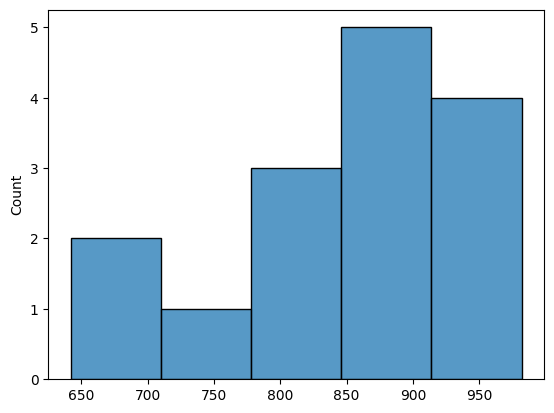

ShapiroResult(statistic=0.9340845942497253, pvalue=0.3137578070163727)


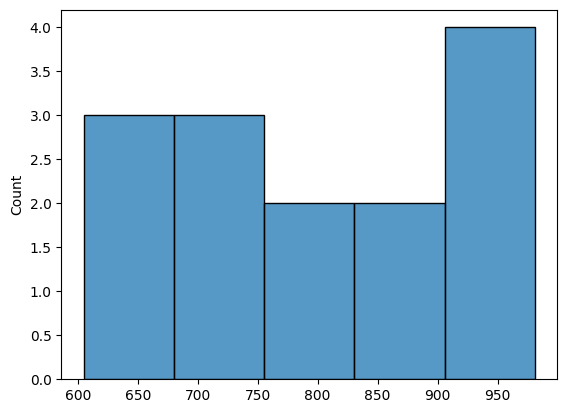

ShapiroResult(statistic=0.9336774349212646, pvalue=0.343319833278656)


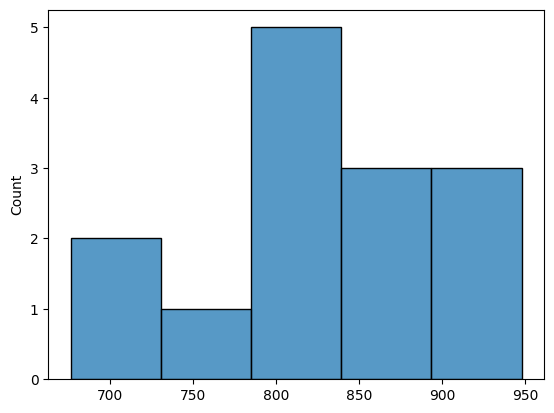

ShapiroResult(statistic=0.9604096412658691, pvalue=0.729839563369751)


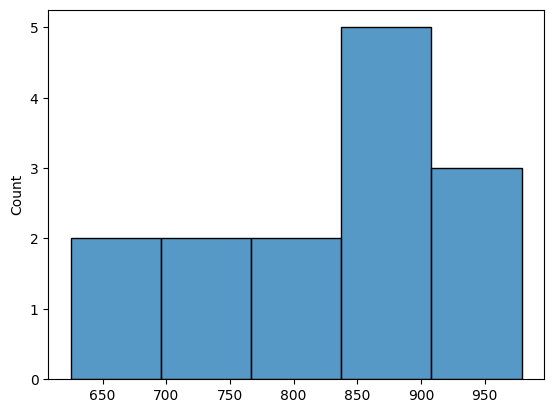

ShapiroResult(statistic=0.9670557975769043, pvalue=0.8350021243095398)


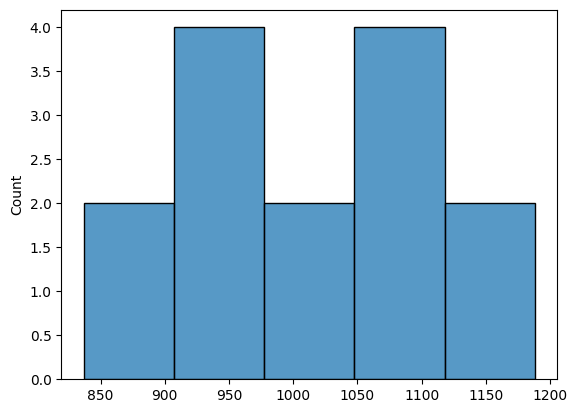

ShapiroResult(statistic=0.9541672468185425, pvalue=0.6270619034767151)


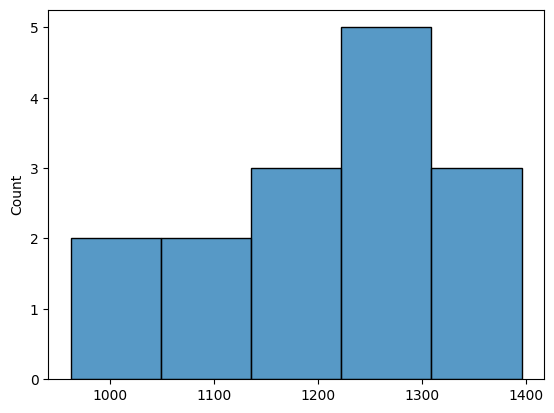

ShapiroResult(statistic=0.9697591662406921, pvalue=0.8544721007347107)


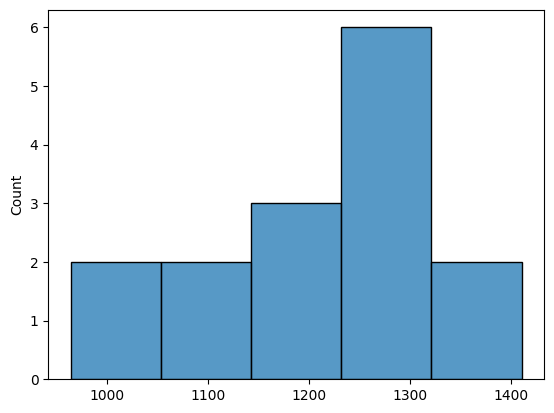

ShapiroResult(statistic=0.9312928318977356, pvalue=0.2852664291858673)
861.0 781.5 830.5 849.5 1036.5 1233.0 1249.0


In [ ]:
df_full['starts'] = [1] * df_full.shape[0]
grrr = df_full[['date', 'day_of_week', 'starts']].groupby(['day_of_week', 'date']).agg(sum)
arrays = []
for i in range(7):
    arrays.append(np.array(grrr['starts'][i].reset_index().drop(columns='date')['starts']))
    sns.histplot(arrays[i])
    plt.show()
    print(shp(arrays[i]))
print(*[np.median(elem) for elem in arrays])

Данные распределены нормально, значит, мы используем Т-критерий для поиска p-value

In [ ]:
def prov_for_hipot(arr1, arr2):
    return hip_right_or_not(ttest(arr1, arr2)[1])


days_week = {0: 'понедельника', 1: 'вторника', 2: 'среды', 3: "четверга", 4: "пятницы", 5: "субботы", 6: "воскресенья"}


for i in range(7):
    for j in range(i + 1, 7):
        print(f'{prov_for_hipot(arrays[i], arrays[j])} для {days_week[i]} и {days_week[j]}')

Нулевая гипотеза отвергается для понедельника и вторника
Нулевая гипотеза отвергается для понедельника и среды
Нулевая гипотеза отвергается для понедельника и четверга
Нулевая гипотеза отвергается для понедельника и пятницы
Нулевая гипотеза отвергается для понедельника и субботы
Нулевая гипотеза отвергается для понедельника и воскресенья
Нулевая гипотеза отвергается для вторника и среды
Нулевая гипотеза отвергается для вторника и четверга
Нулевая гипотеза отвергается для вторника и пятницы
Нулевая гипотеза отвергается для вторника и субботы
Нулевая гипотеза отвергается для вторника и воскресенья
Нулевая гипотеза отвергается для среды и четверга
Нулевая гипотеза отвергается для среды и пятницы
Нулевая гипотеза отвергается для среды и субботы
Нулевая гипотеза отвергается для среды и воскресенья
Нулевая гипотеза отвергается для четверга и пятницы
Нулевая гипотеза отвергается для четверга и субботы
Нулевая гипотеза отвергается для четверга и воскресенья
Нулевая гипотеза отвергается для пят

А из данных по графикам и медианных значений спроса на самокаты, мы можем заявить, что самый большой спрос на самокаты в воскресенье, а самый маленький во вторник

____________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Гипотеза номер 1: в дождливое время спрос на самокаты такой же

In [ ]:
groupping_for_hipot_1 = df_full[['date', 'precipitation_total', 'starts']].groupby(['precipitation_total', 'date']).sum()
set(df_full['precipitation_total'])

{0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8}

In [ ]:
for i in np.arange(0.0, 0.8, 0.1):
    for j in np.arange(i + 0.1, 0.8, 0.1):
        if round(i, 1) == 0.7 or round(j, 1) == 0.7:
            continue
        arr1 = np.array(groupping_for_hipot_1['starts'][round(i, 1)].reset_index().drop(columns='date')['starts'])
        arr2 = np.array(groupping_for_hipot_1['starts'][round(j, 1)].reset_index().drop(columns='date')['starts'])
        print(f'{hip_right_or_not(mnw(arr1, arr2)[0])} для {round(i, 1)} и {round(j, 1)}')

Нулевая гипотеза отвергается для 0.0 и 0.1
Нулевая гипотеза отвергается для 0.0 и 0.2
Нулевая гипотеза отвергается для 0.0 и 0.3
Нулевая гипотеза отвергается для 0.0 и 0.4
Нулевая гипотеза отвергается для 0.0 и 0.5
Нулевая гипотеза отвергается для 0.0 и 0.6
Нулевая гипотеза отвергается для 0.1 и 0.2
Нулевая гипотеза отвергается для 0.1 и 0.3
Нулевая гипотеза отвергается для 0.1 и 0.4
Нулевая гипотеза отвергается для 0.1 и 0.5
Нулевая гипотеза отвергается для 0.1 и 0.6
Нулевая гипотеза отвергается для 0.1 и 0.8
Нулевая гипотеза отвергается для 0.2 и 0.3
Нулевая гипотеза отвергается для 0.2 и 0.4
Нулевая гипотеза отвергается для 0.2 и 0.5
Нулевая гипотеза отвергается для 0.2 и 0.6
Нулевая гипотеза отвергается для 0.3 и 0.4
Нулевая гипотеза отвергается для 0.3 и 0.5
Нулевая гипотеза отвергается для 0.3 и 0.6
Нулевая гипотеза отвергается для 0.4 и 0.5
Нулевая гипотеза отвергается для 0.4 и 0.6
Нулевая гипотеза отвергается для 0.4 и 0.8
Нулевая гипотеза отвергается для 0.5 и 0.6
Нулевая гип

А значит, что мы принимает альтернативную гипотезу - дождь влияет на спрос

___________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________________

Гипотеза номер 2: средняя стоимость поездки по районам одинаковая

In [ ]:
def price(x): # разбиваем по цене и времени
    if x['start_date'].hour in list(range(1, 6)):
        price_for_dr = 3 * int(x['time'])
    elif x['start_date'].hour in list(range(6, 10)):
        price_for_dr = 4 * int(x['time'])
    else:
        if x['day_of_week'] < 5:
            if x['start_date'].hour in list(range(16, 22)):
                price_for_dr = 6 * int(x['time'])
            else:
                price_for_dr = 5 * int(x['time'])
        else:
            if x['start_date'].hour in list(range(16, 22)):
                price_for_dr = 7 * int(x['time'])
            else:
                price_for_dr = 6 * int(x['time'])
    return (not x['promo']) * 30  + price_for_dr

In [ ]:
df_full.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго_восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо_западный    3881.0      0   
4  северо_западный    юбилейная    юго_восточный    4029.0      0   

   day_of_week  ...       avg_V  temperature  precipitation_total  wind_gust  \
0            5  ...  171.687764     8.640245                  0.0      15.48   
1            5  ...  158.885630     8.640245                  0.0      15.48   
2            5  ...  117.964332     8.640245                  0.0      15.48   
3            5  ...  121.980094     8.640245                  0.0      15.48   
4            5  ...  131.380435     8.640245                  0.0      15.48   

   wind_speed  cloud_cover_total  sunshine_duration  day_cat        date  \
0    8.217153               65.0                0.0  weekend  2023-04-22   
1    8.217153               65.0                0.0  weekend  2023-04-22   
2    8.217153               65.0                0.0  weekend  2023-04-22   
3    8.217153               65.0                0.0  weekend  2023-04-22   
4    8.217153               65.0                0.0  weekend  2023-04-22   

  starts  
0      1  
1      1  
2      1  
3      1  
4      1  

[5 rows x 21 columns]

Удалим ненужные для дальнейшей работы с данными столбцы

In [ ]:
df_full= df_full.drop(columns=['day_cat', 'date'])

In [ ]:
df_full['total_price'] = df_full.apply(price, axis=1)
df_full.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo  \
0    юго_восточный      майская      октябрьский    4069.0      0   
1         заречный   спортивная      октябрьский    4515.0      0   
2      октябрьский     суворова        ленинский    4520.0      0   
3      центральный      рабочая  северо_западный    3881.0      0   
4  северо_западный    юбилейная    юго_восточный    4029.0      0   

   day_of_week       time       avg_V  temperature  precipitation_total  \
0            5  23.700000  171.687764     8.640245                  0.0   
1            5  28.416667  158.885630     8.640245                  0.0   
2            5  38.316667  117.964332     8.640245                  0.0   
3            5  31.816667  121.980094     8.640245                  0.0   
4            5  30.666667  131.380435     8.640245                  0.0   

   wind_gust  wind_speed  cloud_cover_total  sunshine_duration  starts  \
0      15.48    8.217153               65.0                0.0       1   
1      15.48    8.217153               65.0                0.0       1   
2      15.48    8.217153               65.0                0.0       1   
3      15.48    8.217153               65.0                0.0       1   
4      15.48    8.217153               65.0                0.0       1   

   total_price  
0          122  
1          142  
2          182  
3          154  
4          150

Создадим новый группировку по стартам в районах

In [ ]:
groupping_by_distr = df_full[['start_district', 'total_price']].groupby('start_district').median()
groupping_by_distr

total_price
start_district              
заречный               171.5
ленинский              162.0
октябрьский            160.0
северо_западный        170.0
центральный            162.0
юго_восточный          168.0

По этим данным, самая большая выручка в среднем идет из Заречного района, а самая маленькая из Октябрьского

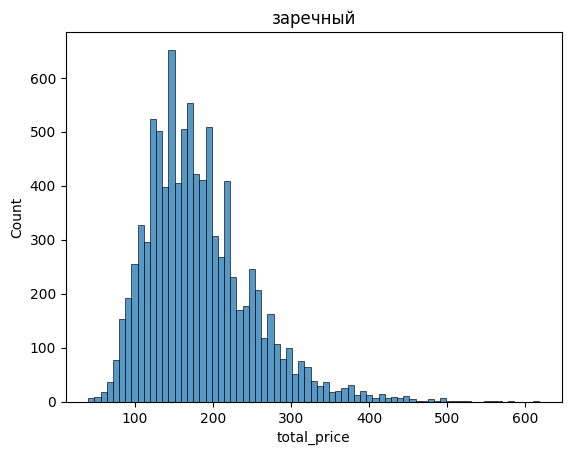

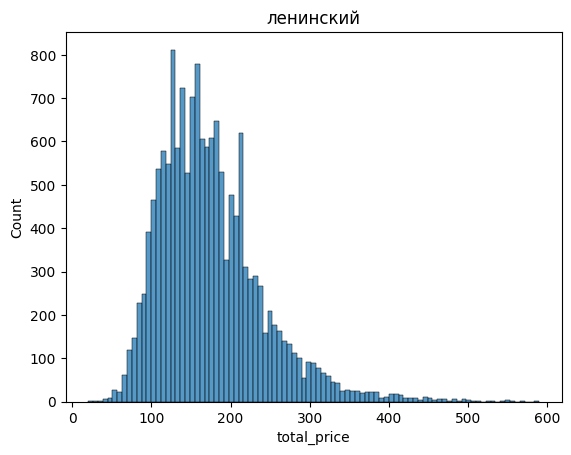

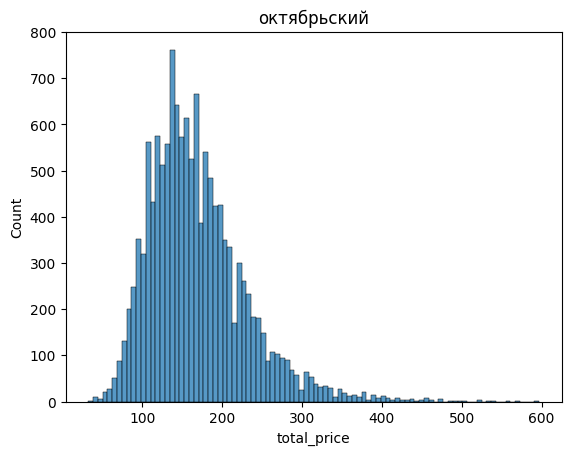

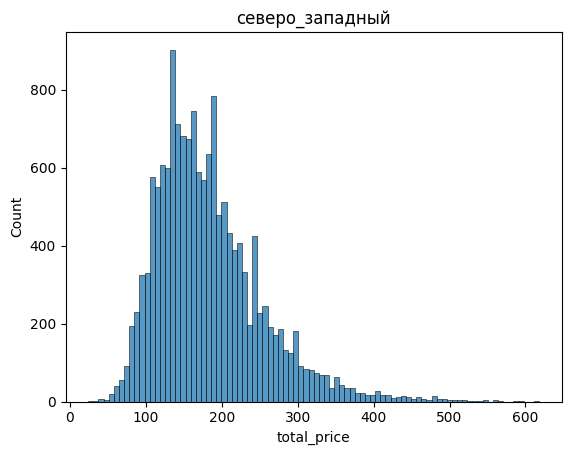

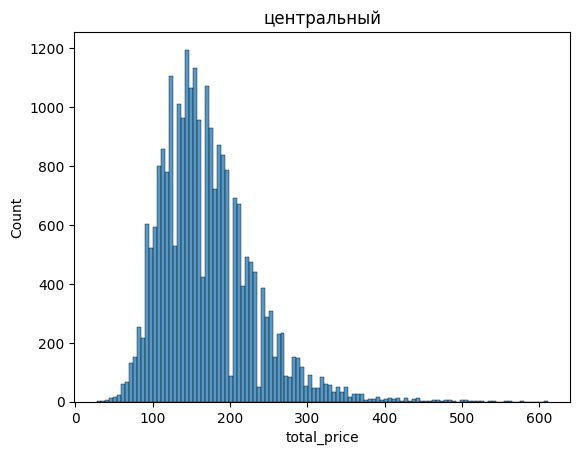

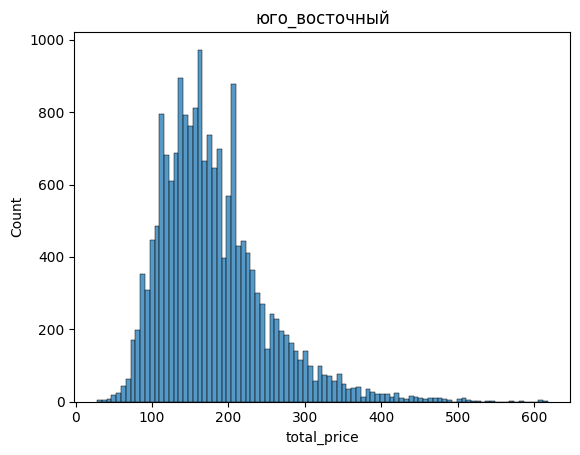

In [ ]:
districts = ['заречный', 'ленинский', 'октябрьский', 'северо_западный', 'центральный', 'юго_восточный']
for dis in districts:
    sns.histplot(df_full[df_full.start_district == dis]['total_price'])
    plt.title(dis)
    plt.show()

In [ ]:
for i in range(len(districts)):
    for j in range(i + 1, len(districts)):
        arr1 = df_full[df_full.start_district == districts[i]]['total_price']
        arr2 = df_full[df_full.start_district == districts[j]]['total_price']
        if shp(arr1)[1] >= 0.05 and shp(arr2)[1] >= 0.05:
            print(f'{prov_for_hipot(arr1, arr2)} для районов {districts[i]} и {districts[j]}')
        else:
            print(f'{hip_right_or_not(mnw(arr1, arr2)[0])} для районов {districts[i]} и {districts[j]}')

/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Нулевая гипотеза отвергается для районов заречный и ленинский
Нулевая гипотеза отвергается для районов заречный и октябрьский
Нулевая гипотеза отвергается для районов заречный и северо_западный
Нулевая гипотеза отвергается для районов заречный и центральный
Нулевая гипотеза отвергается для районов заречный и юго_восточный
Нулевая гипотеза отвергается для районов ленинский и октябрьский
Нулевая гипотеза отвергается для районов ленинский и северо_западный
Нулевая гипотеза отвергается для районов ленинский и центральный
Нулевая гипотеза отвергается для районов ленинский и юго_восточный
Нулевая гипотеза отвергается для районов октябрьский и северо_западный
Нулевая гипотеза отвергается для районов октябрьский и центральный
Нулевая гипотеза отвергается для районов октябрьский и юго_восточный
Нулевая гипотеза отвергается для районов северо_западный и центральный
Нулевая гипотеза отвергается для районов северо_западный и юго_восточный
Нулевая гипотеза отвергается для районов центральный и юго_

Гипотеза отвергается, следовательно среднии выручки в разных районах разные

____________________________________________________________________________________________________________________________

____________________________________________________________________________________________________________________________

____________________________________________________________________________________________________________________________

In [ ]:
set(df_full['sunshine_duration']) #== {0.0}, а если у нас только 1 значение, значит мы можем удалять
df_full = df_full.drop(columns='sunshine_duration')

Для создания регрессионной модели необходимо сначала выявить факторы, наиболее влияющие на целевой - спрос

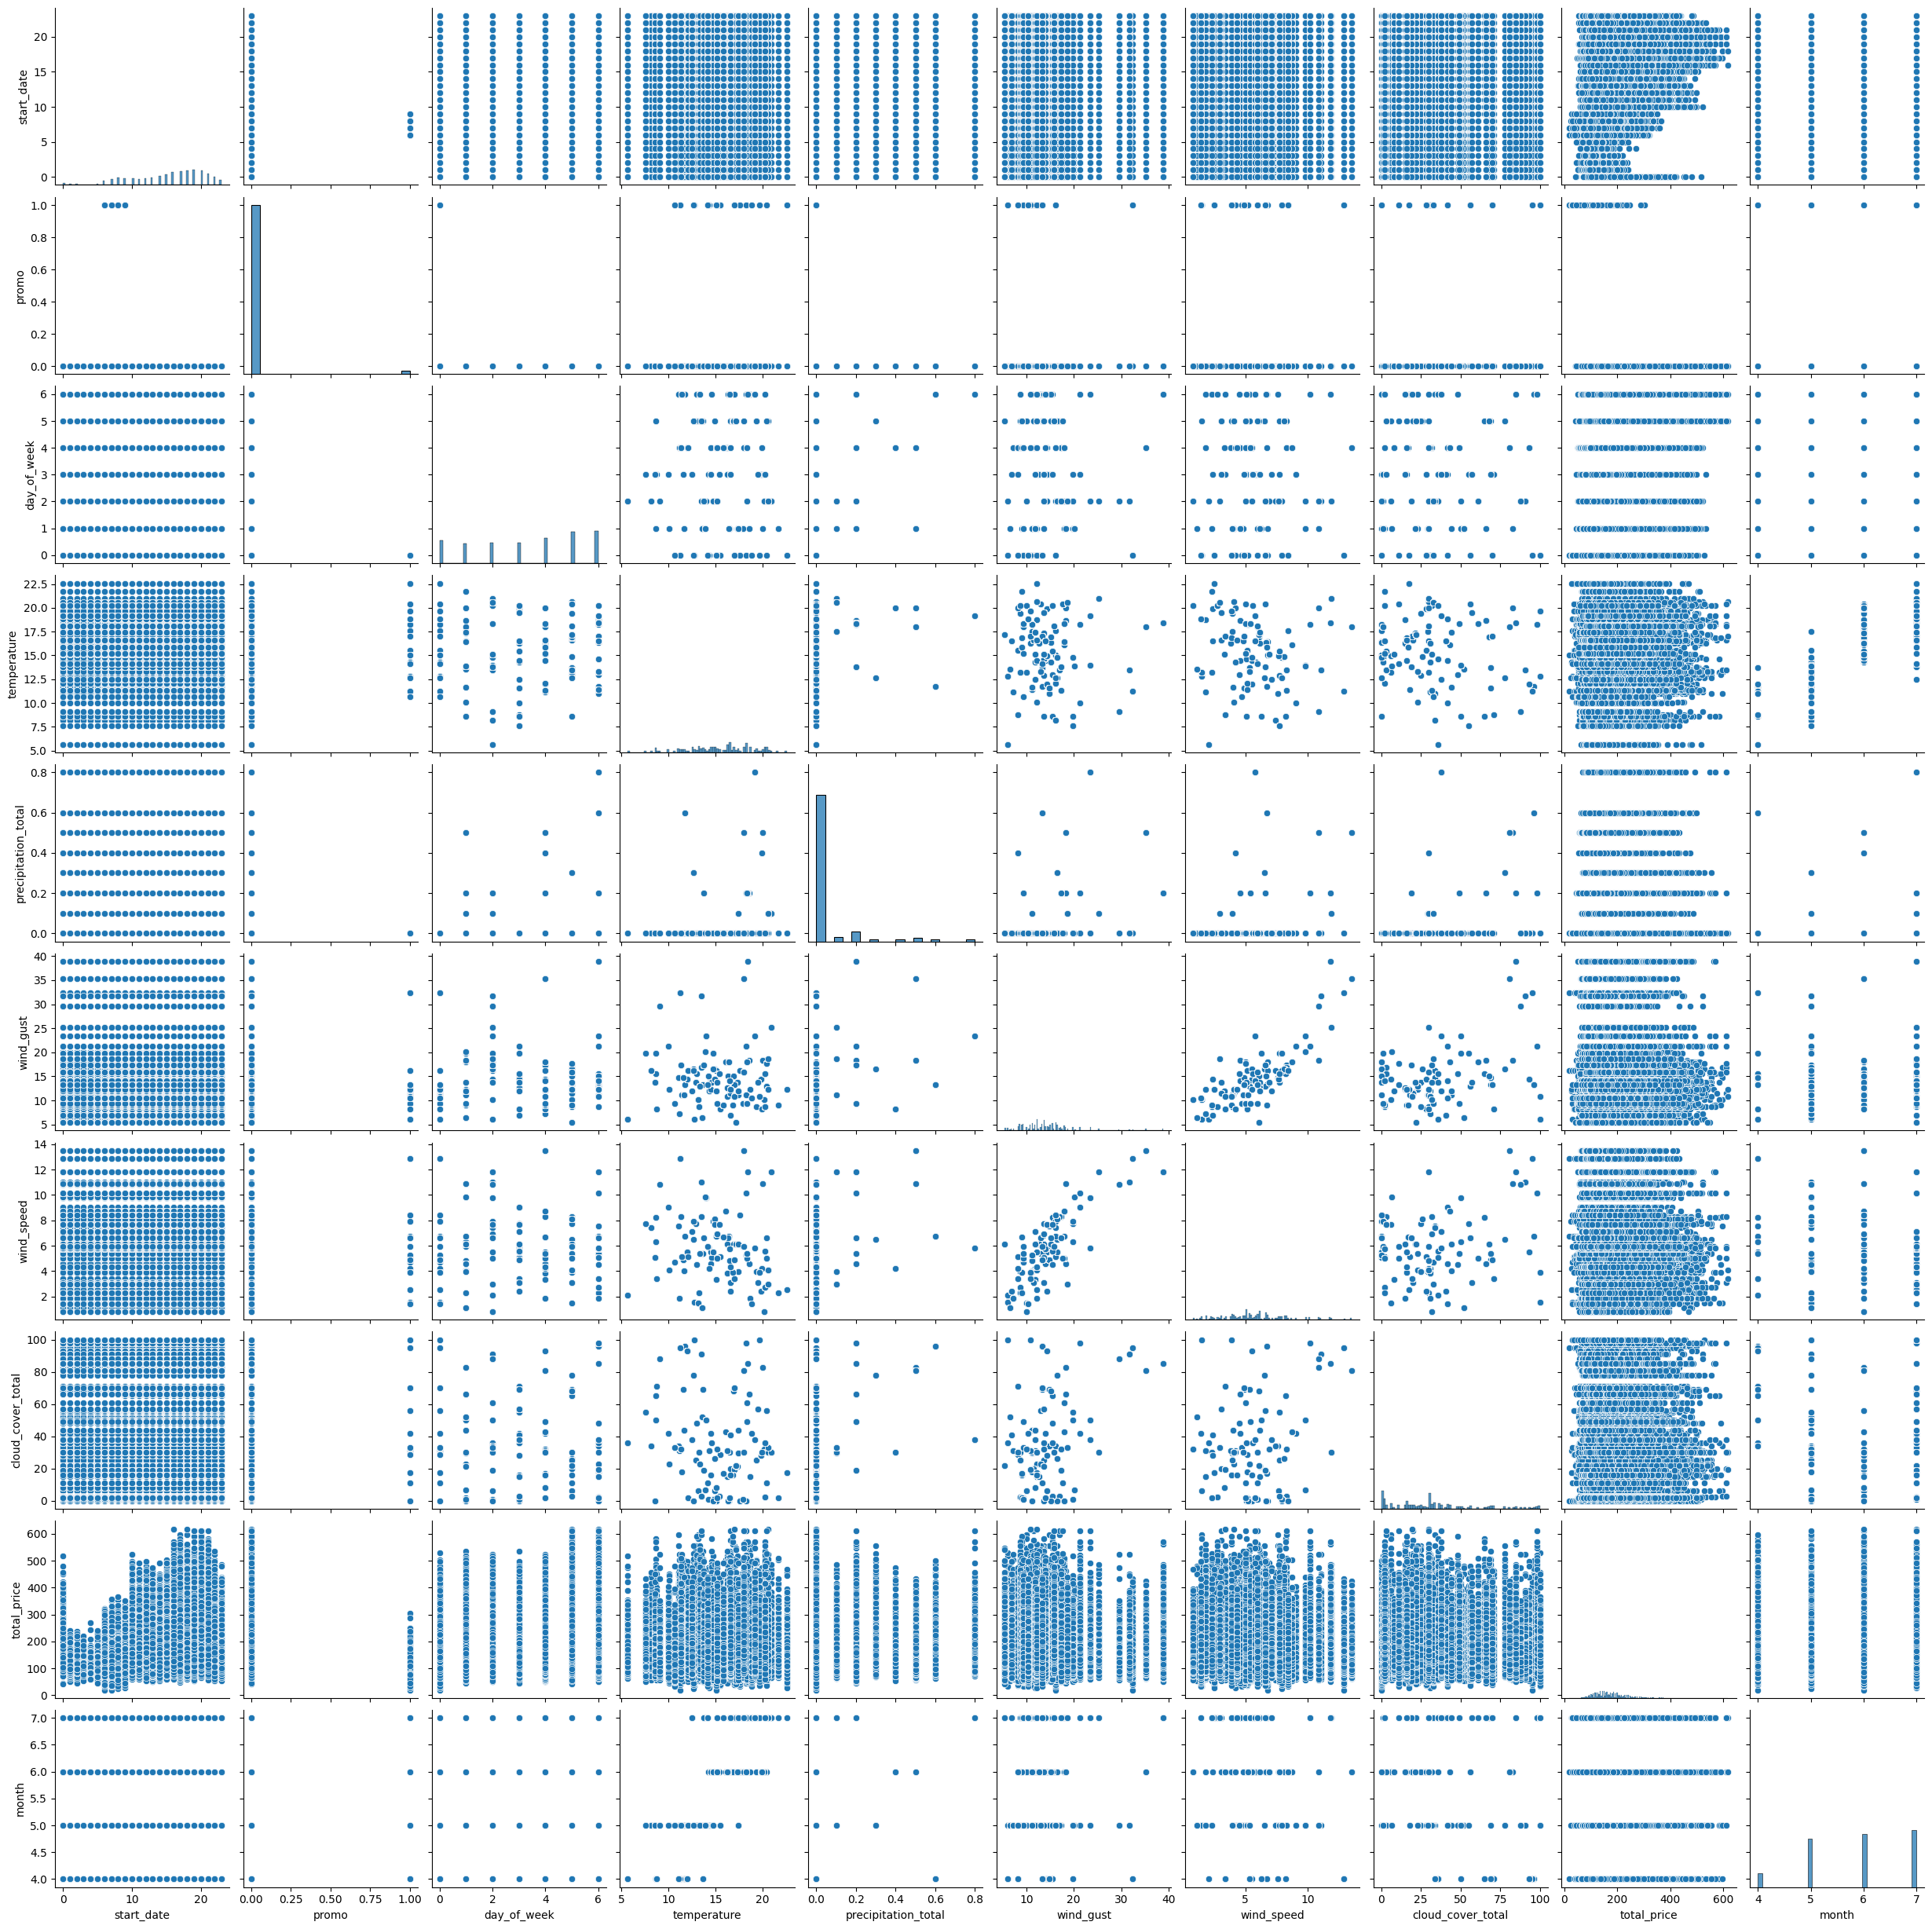

In [ ]:
sns.pairplot(df) # данные, имеющие в соотношении с итоговой ценой графики из столбов вверх будем считать категориальными
plt.show()

In [ ]:
df = df_full.copy()
df = df.drop(columns=['id', 'end_date', 'avg_V', 'distance', 'end_location','end_district', 'time', 'starts']) # id поездки точно никак не влияет на спрос, а конец поездки будет оказывать примерно такое же влияение, что и time, итоговая цена также не влияет на предугадывание
# а также дистанцию и время мы не знаем заранее для построения модели для предугадывания спроса, как и конечные точки маршрута и время
df['month'] = df['start_date'].apply(lambda x: x.month) # добавим номер месяца, ведь наш спрос может меняться в зависимости от каникул у людей и так далее
df['start_date'] = df['start_date'].apply(lambda x: x.hour)
df.head()

start_date start_location   start_district  promo  day_of_week  \
0           9       шевченко    юго_восточный      0            5   
1           9         чехова         заречный      0            5   
2           9      буденного      октябрьский      0            5   
3           9          труда      центральный      0            5   
4           9   первомайская  северо_западный      0            5   

   temperature  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0     8.640245                  0.0      15.48    8.217153               65.0   
1     8.640245                  0.0      15.48    8.217153               65.0   
2     8.640245                  0.0      15.48    8.217153               65.0   
3     8.640245                  0.0      15.48    8.217153               65.0   
4     8.640245                  0.0      15.48    8.217153               65.0   

   total_price  month  
0          122      4  
1          142      4  
2          182      4  
3          154      4  
4          150      4

Далее нам нужно преобразовать категориальные названия через OneHotEncoder

In [ ]:
ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
    )

df_encoded = pd.DataFrame( # создаем новый датафрем с шифровкой начальной локации через onehotencoder
        ohe.fit_transform(df[['precipitation_total', 'start_location', 'start_district', 'month', 'day_of_week', 'start_date', 'precipitation_total']])).rename( # обрабатываем все категориальные столбцы через OneHotEncoder
            columns=lambda x: str(x)) #так как линейная регрессия принимает только стринговые значения стоблцов
df = df.join(df_encoded)
df = df.drop(columns=['start_location', 'start_district', 'month', 'day_of_week', 'start_date', 'precipitation_total']).dropna() # удаляем категориальные названия
df.head()

promo  temperature  wind_gust  wind_speed  cloud_cover_total  total_price  \
0      0     8.640245      15.48    8.217153               65.0          122   
1      0     8.640245      15.48    8.217153               65.0          142   
2      0     8.640245      15.48    8.217153               65.0          182   
3      0     8.640245      15.48    8.217153               65.0          154   
4      0     8.640245      15.48    8.217153               65.0          150   

     0    1    2    3  ...  138  139  140  141  142  143  144  145  146  147  
0  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
3  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
4  1.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 154 columns]

In [ ]:
df.corr().iloc[:6, :20] # проверяем зависимость конечной цены от начальных параметров без учета многих, тк 139 стоблцов очень трудно проанализировать глазами (?) вроде от всех +- зависит

promo  temperature  wind_gust  wind_speed  \
promo              1.000000     0.050970  -0.033998   -0.025660   
temperature        0.050970     1.000000  -0.033813   -0.143856   
wind_gust         -0.033998    -0.033813   1.000000    0.794333   
wind_speed        -0.025660    -0.143856   0.794333    1.000000   
cloud_cover_total  0.011639    -0.105325   0.369218    0.266584   
total_price       -0.167451     0.000758  -0.014037   -0.012295   

                   cloud_cover_total  total_price         0         1  \
promo                       0.011639    -0.167451  0.000105  0.031752   
temperature                -0.105325     0.000758 -0.176512  0.145805   
wind_gust                   0.369218    -0.014037 -0.018791 -0.020210   
wind_speed                  0.266584    -0.012295 -0.083213 -0.082775   
cloud_cover_total           1.000000    -0.004964 -0.108579 -0.069673   
total_price                -0.004964     1.000000 -0.017042  0.048333   

                          2         3         4         5         6         7  \
promo              0.016267 -0.015115 -0.013819 -0.019284 -0.013896 -0.016266   
temperature        0.188609 -0.149375  0.066739  0.129430 -0.111812 -0.012980   
wind_gust          0.034477  0.060467 -0.033052 -0.013653 -0.016200  0.018364   
wind_speed         0.083140  0.101540 -0.001424  0.036335  0.041060  0.031533   
cloud_cover_total  0.126818  0.007142 -0.082723  0.069757  0.212832 -0.025788   
total_price       -0.006651 -0.012221 -0.022202  0.011223  0.033973 -0.013341   

                          8         9        10        11        12        13  
promo             -0.000744  0.001809 -0.003523 -0.000113 -0.002461  0.005467  
temperature        0.005226 -0.004567  0.001422  0.000546 -0.000654 -0.001880  
wind_gust          0.001369 -0.001005  0.001687  0.003646 -0.004956 -0.001061  
wind_speed         0.000721 -0.002407 -0.000250  0.001216 -0.002838 -0.004345  
cloud_cover_total -0.004439 -0.000603 -0.000249  0.000463 -0.001509 -0.001922  
total_price        0.002211  0.002993 -0.003903 -0.000503  0.004320  0.002013

In [ ]:
X = df.drop(columns='total_price')[:60000]
Y = df['total_price'][:60000]
x_train, x_test, y_train, y_test = tr(X, Y, test_size=0.15, shuffle=False) # разделяем выборки на тестовые и проверочные без перемешивания для соблюдения временной адекватности
lin_regr = LinearRegression() # подгружаем линейную регрессию
model = lin_regr.fit(x_train, y_train) # создаем саму модель
predicts = model.predict(x_test)

In [ ]:
ans_r2 = r2_score(y_test, predicts).round(2) # проверяем модель
ans_mape = (mean_absolute_percentage_error(y_test, predicts) * 100).round(2) # проверяем модель
ans_r2, ans_mape

(-2.6066176513490022e+19, 94859613814.21)

In [ ]:
df = df_full.copy()
df = df.drop(columns=['id', 'end_date', 'avg_V', 'distance', 'end_location','end_district', 'time', 'total_price']) # id поездки точно никак не влияет на спрос, а конец поездки будет оказывать примерно такое же влияение, что и time, итоговая цена также не влияет на предугадывание
# а также дистанцию и время мы не знаем заранее для построения модели для предугадывания спроса, как и конечные точки маршрута и время
df['month'] = df['start_date'].apply(lambda x: x.month) # добавим номер месяца, ведь наш спрос может меняться в зависимости от каникул у людей и так далее
df['time_start'] = df['start_date'].apply(lambda x: x.hour)
df['date'] = df['start_date'].apply(lambda x: x.day)
df = df.drop(columns='start_date')
df.head()

start_location   start_district  promo  day_of_week  temperature  ...  \
0       шевченко    юго_восточный      0            5     8.640245  ...   
1         чехова         заречный      0            5     8.640245  ...   
2      буденного      октябрьский      0            5     8.640245  ...   
3          труда      центральный      0            5     8.640245  ...   
4   первомайская  северо_западный      0            5     8.640245  ...   

   cloud_cover_total  starts  month  time_start  date  
0               65.0       1      4           9    22  
1               65.0       1      4           9    22  
2               65.0       1      4           9    22  
3               65.0       1      4           9    22  
4               65.0       1      4           9    22  

[5 rows x 13 columns]

In [ ]:
df_with_starts = df.groupby(['month', 'date', 'time_start', 'day_of_week', 'start_location', 'start_district', 'promo', 'temperature', 'precipitation_total', 'wind_gust', 'wind_speed', 'cloud_cover_total']).sum().reset_index().drop(columns='date') # чтоб они
# отсортировались по датам и времени
df_with_starts.head()

month  time_start  day_of_week start_location start_district  promo  \
0      4           9            5      буденного    октябрьский      0   
1      4           9            5      восточная    октябрьский      0   
2      4           9            5       западная      ленинский      0   
3      4           9            5        зеленая    центральный      0   
4      4           9            5       комарова      ленинский      0   

   temperature  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0     8.640245                  0.0      15.48    8.217153               65.0   
1     8.640245                  0.0      15.48    8.217153               65.0   
2     8.640245                  0.0      15.48    8.217153               65.0   
3     8.640245                  0.0      15.48    8.217153               65.0   
4     8.640245                  0.0      15.48    8.217153               65.0   

   starts  
0       2  
1       1  
2       1  
3       1  
4       1

In [ ]:
X = df_with_starts.drop(columns='starts')
Y = df_with_starts['starts']
x_train, x_test, y_train, y_test = tr(X, Y, test_size=0.05, random_state=42) # разделяем выборки на тестовые и проверочные без перемешивания для соблюдения временной адекватности

In [ ]:
ohe = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False,
    drop='first'
    )


def enc(x):
    df_encoded = pd.DataFrame( # создаем новый датафрем с шифровкой начальной локации через onehotencoder
        ohe.fit_transform(df[['month','time_start','day_of_week','start_location','start_district']])).rename( # обрабатываем все категориальные столбцы через OneHotEncoder
            columns=lambda x: str(x)) #так как линейная регрессия принимает только стринговые значения стоблцов
    x = x.join(df_encoded)
    return x.drop(columns=['month','time_start','day_of_week','start_location','start_district']) # удаляем категориальные названия


x_test = enc(x_test)
x_train = enc(x_train)
x_test.head()

promo  temperature  precipitation_total  wind_gust  wind_speed  \
14361      0    11.380245                  0.0  11.159999    5.154415   
23730      0    12.660245                  0.0  16.199999    7.895416   
26306      0    16.100246                  0.0  18.000000    8.707238   
14360      0    11.380245                  0.0  11.159999    5.154415   
39285      0    20.430244                  0.0  12.959999    6.618519   

       cloud_cover_total    0    1    2    3  ...  117  118  119  120  121  \
14361               18.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
23730                0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
26306               43.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
14360               18.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   
39285               56.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.0   

       122  123  124  125  126  
14361  0.0  0.0  0.0  1.0  0.0  
23730  0.0  0.0  0.0  1.0  0.0  
26306  0.0  0.0  0.0  0.0  1.0  
14360  0.0  0.0  1.0  0.0  0.0  
39285  0.0  0.0  1.0  0.0  0.0  

[5 rows x 133 columns]

In [ ]:
lin_regr = LinearRegression() # подгружаем линейную регрессию
model = lin_regr.fit(x_train, y_train) # создаем саму модель
predicts = np.array(model.predict(x_test)).round()

In [ ]:
ans_r2 = mean_squared_error(y_test, predicts).round(2) # проверяем нашу модель
ans_mape = (mean_absolute_percentage_error(y_test, predicts) * 100).round(2)
print(ans_r2, ans_mape) # 0.71, 18.12 - все хорошо

(0.71, 18.12)

In [ ]:
filename = 'linear_model.sav'
pickle.dump(model, open(filename, 'wb'))
load_model = pickle.load(open(filename, 'rb'))

In [ ]:
print(pd.DataFrame(zip(x_train.columns, model.coef_)))

0         1
0                  promo -0.172365
1            temperature  0.010320
2    precipitation_total  0.118212
3              wind_gust -0.001894
4             wind_speed  0.003669
..                   ...       ...
128                  122  0.000731
129                  123  0.021629
130                  124 -0.003374
131                  125  0.006827
132                  126  0.005153

[133 rows x 2 columns]

In [41]:
df_req = pd.read_csv('request_data.csv', encoding='utf-8', sep=',', decimal='.', skipinitialspace=True).rename(
    columns=lambda x: x.replace(' ', '_').lower()
)
df_req['time'] = pd.to_datetime(df_req['time'])
df_req.head()

unnamed:_0                time  request
0           0 2023-04-22 09:00:00       19
1           1 2023-04-22 10:00:00       41
2           2 2023-04-22 11:00:00       28
3           3 2023-04-22 12:00:00       45
4           4 2023-04-22 13:00:00       46

In [42]:
def uniting(x):
    datetime_for_unit = x['start_date'].round(freq='h', nonexistent='shift_backward')
    return df_req[df_req.time == pd.to_datetime(datetime_for_unit)]['request'].median()
    

df_full['requests'] = df_full.apply(uniting, axis=1)
days_week = {0: 'Понедельник', 1: 'Вторника', 2: 'Среды', 3: "Четверга", 4: "Пятницы", 5: "Субботы", 6: "Воскресенья"}
df_full['day_of_week'] = df_full['day_of_week'].apply(lambda x: days_week[x])
df_full.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo day_of_week  \
0    юго_восточный      майская      октябрьский    4069.0      0     Субботы   
1         заречный   спортивная      октябрьский    4515.0      0     Субботы   
2      октябрьский     суворова        ленинский    4520.0      0     Субботы   
3      центральный      рабочая  северо_западный    3881.0      0     Субботы   
4  северо_западный    юбилейная    юго_восточный    4029.0      0     Субботы   

        time       avg_V  temperature  precipitation_total  wind_gust  \
0  23.700000  171.687764     8.640245                  0.0      15.48   
1  28.416667  158.885630     8.640245                  0.0      15.48   
2  38.316667  117.964332     8.640245                  0.0      15.48   
3  31.816667  121.980094     8.640245                  0.0      15.48   
4  30.666667  131.380435     8.640245                  0.0      15.48   

   wind_speed  cloud_cover_total  sunshine_duration  requests  
0    8.217153               65.0                0.0      19.0  
1    8.217153               65.0                0.0      19.0  
2    8.217153               65.0                0.0      19.0  
3    8.217153               65.0                0.0      19.0  
4    8.217153               65.0                0.0      19.0

In [44]:
days_week = {'Понедельник': 'Понедельник', 'Вторника': 'Вторник', 'Среды': 'Среда', "Четверга": "Четверг", "Пятницы": "Пятница", "Субботы": "Суббота", "Воскресенья": "Воскресенье"}
df_full['day_of_week'] = df_full['day_of_week'].apply(lambda x: days_week[x])
df_full.to_csv("df_full.csv")